## Testing effects of soil and fire properties on soil microbial communities
## This notebook provides the statistical analyses reported in Table 1

In [1]:
library(phyloseq)
library(vegan)
library(plyr)
library(dplyr)
library(ggplot2)

Loading required package: permute
Loading required package: lattice
This is vegan 2.4-4

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# Importing the phyloseq object
ps = readRDS("../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/ps.merged")

In [3]:
ps.norm = transform_sample_counts(ps, function(x) (x / sum(x)))
ps.hell = transform_sample_counts(ps, function(x) (x / sum(x))^0.5)
# Hellinger Transformation: "Particularly suited to species abundance data, 
    # this transformation gives low weights to variables with low counts and many zeros. 
    # The transformation itself comprises dividing each value in a data matrix by its row sum, 
    # and taking the square root of the quotient.

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,4,0.008753727,0.002188432,0.6573448,0.6231212
Residuals,97,0.322932334,0.003329199,NA,NA


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                   diff         lwr        upr     p adj
Jack Pine-Black Spruce      0.006169916 -0.04320254 0.05554237 0.9968237
Mixedwood-Black Spruce     -0.009029738 -0.05868153 0.04062205 0.9866431
Open Wetland-Black Spruce   0.013094852 -0.04361149 0.06980119 0.9677483
Treed Wetland-Black Spruce  0.019077879 -0.04775119 0.08590694 0.9319124
Mixedwood-Jack Pine        -0.015199655 -0.05627678 0.02587747 0.8415509
Open Wetland-Jack Pine      0.006924935 -0.04244752 0.05629739 0.9950348
Treed Wetland-Jack Pine     0.012907962 -0.04782221 0.07363814 0.9761581
Open Wetland-Mixedwood      0.022124590 -0.02752720 0.07177638 0.7288431
Treed Wetland-Mixedwood     0.028107617 -0.03284987 0.08906510 0.7029878
Treed Wetland-Open Wetland  0.005983027 -0.06084604 0.07281209 0.9991393


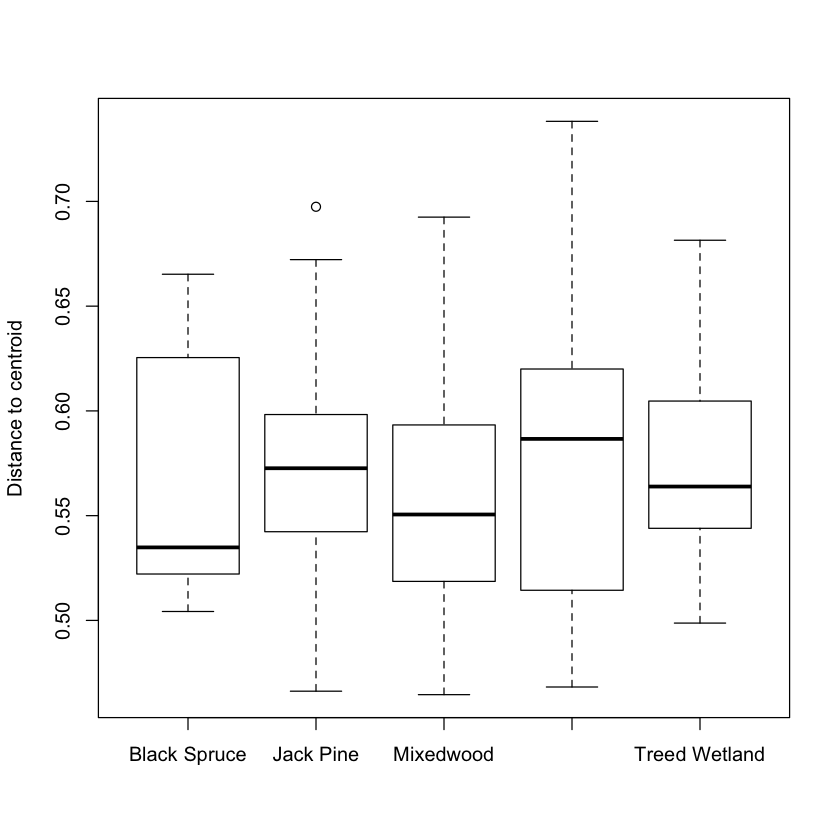

In [6]:
physeq = ps.hell
#physeq = subset_samples(physeq,Land_Class=="Wetland")
#physeq = subset_samples(physeq,Land_Class=="Upland")

df = as(sample_data(physeq), "data.frame")

d = distance(physeq, method = "bray", weighted=TRUE)
sampdat = sample_data(physeq)
groups = as.factor(sampdat$Veg_Comm)
x = betadisper(d, groups)
boxplot(x, ylab = "Distance to centroid")
anova(x)
TukeyHSD(x, ordered = FALSE, conf.level = 0.95)
# Performing test of beta dispersion - the permanova/adonis test requires that groups have similar dispersion.
# This doesn't look outrageously bad here for the different vegetation communities - no significant differences.
# Looks generally okay for Severity_Class
# Land_Class barely not significant
# Mineral / Organic also have diff betadispersion - but not using as categorical (TC_pct)

In [81]:
# Creating the function to test different models of microbial community composition prediction
# Swapping in and out each severity metric

AdonisFunction = function(physeq=ps.hell, method="bray", Org_or_Min=c("O","M"), Land_Class=c("Upland","Wetland")){
    physeq = prune_samples(sample_data(physeq)$Land_Class %in% Land_Class, physeq)
    physeq = prune_samples(!is.na(sample_data(physeq)$pH), physeq)
    d = distance(physeq, method = method, weighted=TRUE)  
    d.adonis = adonis(d ~ 
                      + sample_data(physeq)$Veg_Comm
                      + as.numeric(sample_data(physeq)$Moisture_Regime)
                      + sample_data(physeq)$pH
                      + sample_data(physeq)$TC_pct
                      + sample_data(physeq)$Sand_pct 
                      
                      + sample_data(physeq)$Burned_Unburned                      
                      #+ sample_data(physeq)$RBR
                      #+ sample_data(physeq)$CFSI
                      #+ sample_data(physeq)$CBI
                      #+ sample_data(physeq)$Understory_CBI
                      #+ sample_data(physeq)$Overstory_CBI
                      #+ sample_data(physeq)$Burn_Severity_Index
                      #+ sample_data(physeq)$Pct_Exposed_Mineral
                      #+ sample_data(physeq)$Mean_Duff_Depth_cm
                      , df)
    d.adonis
}

In [78]:
# Getting results of model when including uplands and wetlands together
Both = AdonisFunction()
Both = data.frame(Both$aov.tab)
Both$R2full = 1-Both$R2

In [12]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.1188655,1.0297164,3.599962,0.11959029,0.001,0.8804097
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.6252689,0.6252689,2.185985,0.01815453,0.002,0.9818455
sample_data(physeq)$pH,1,2.4774460,2.4774460,8.661329,0.07193206,0.001,0.9280679
sample_data(physeq)$TC_pct,1,1.1069738,1.1069738,3.870060,0.03214072,0.001,0.9678593
sample_data(physeq)$Sand_pct,1,0.5317647,0.5317647,1.859087,0.01543966,0.009,0.9845603
sample_data(physeq)$Burned_Unburned,1,1.2681491,1.2681491,4.433540,0.03682041,0.001,0.9631796
Residuals,85,24.3130032,0.2860353,NA,0.70592232,NA,0.2940777
Total,94,34.4414712,NA,NA,1.00000000,NA,0.0000000


In [15]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.1188655,1.0297164,3.556380,0.11959029,0.001,0.8804097
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.6252689,0.6252689,2.159521,0.01815453,0.003,0.9818455
sample_data(physeq)$pH,1,2.4774460,2.4774460,8.556473,0.07193206,0.001,0.9280679
sample_data(physeq)$TC_pct,1,1.1069738,1.1069738,3.823208,0.03214072,0.001,0.9678593
sample_data(physeq)$Sand_pct,1,0.5317647,0.5317647,1.836581,0.01543966,0.010,0.9845603
sample_data(physeq)$RBR,1,0.9702051,0.9702051,3.350844,0.02816968,0.001,0.9718303
Residuals,85,24.6109472,0.2895406,NA,0.71457305,NA,0.2854269
Total,94,34.4414712,NA,NA,1.00000000,NA,0.0000000


In [18]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.1188655,1.0297164,3.515640,0.11959029,0.001,0.8804097
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.6252689,0.6252689,2.134782,0.01815453,0.003,0.9818455
sample_data(physeq)$pH,1,2.4774460,2.4774460,8.458454,0.07193206,0.001,0.9280679
sample_data(physeq)$TC_pct,1,1.1069738,1.1069738,3.779411,0.03214072,0.001,0.9678593
sample_data(physeq)$Sand_pct,1,0.5317647,0.5317647,1.815542,0.01543966,0.010,0.9845603
sample_data(physeq)$CFSI,1,0.6850067,0.6850067,2.338738,0.01988901,0.001,0.9801110
Residuals,85,24.8961456,0.2928958,NA,0.72285372,NA,0.2771463
Total,94,34.4414712,NA,NA,1.00000000,NA,0.0000000


In [23]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.1188655,1.0297164,3.576924,0.11959029,0.001,0.8804097
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.6252689,0.6252689,2.171995,0.01815453,0.005,0.9818455
sample_data(physeq)$pH,1,2.4774460,2.4774460,8.605900,0.07193206,0.001,0.9280679
sample_data(physeq)$TC_pct,1,1.1069738,1.1069738,3.845293,0.03214072,0.001,0.9678593
sample_data(physeq)$Sand_pct,1,0.5317647,0.5317647,1.847190,0.01543966,0.010,0.9845603
sample_data(physeq)$CBI,1,1.1115532,1.1115532,3.861200,0.03227368,0.001,0.9677263
Residuals,85,24.4695992,0.2878776,NA,0.71046905,NA,0.2895310
Total,94,34.4414712,NA,NA,1.00000000,NA,0.0000000


In [32]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,3.5815701,0.8953925,3.118886,0.10996559,0.001,0.8900344
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.6552173,0.6552173,2.282293,0.02011725,0.001,0.9798827
sample_data(physeq)$pH,1,2.4353364,2.4353364,8.482913,0.07477257,0.001,0.9252274
sample_data(physeq)$TC_pct,1,1.1061164,1.1061164,3.852893,0.03396129,0.001,0.9660387
sample_data(physeq)$Sand_pct,1,0.5206855,0.5206855,1.813684,0.01598670,0.012,0.9840133
sample_data(physeq)$Overstory_CBI,1,1.0169224,1.0169224,3.542207,0.03122275,0.001,0.9687772
Residuals,81,23.2540687,0.2870873,NA,0.71397384,NA,0.2860262
Total,90,32.5699169,NA,NA,1.00000000,NA,0.0000000


In [38]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.1188655,1.0297164,3.582083,0.11959029,0.001,0.8804097
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.6252689,0.6252689,2.175128,0.01815453,0.003,0.9818455
sample_data(physeq)$pH,1,2.4774460,2.4774460,8.618313,0.07193206,0.001,0.9280679
sample_data(physeq)$TC_pct,1,1.1069738,1.1069738,3.850839,0.03214072,0.001,0.9678593
sample_data(physeq)$Sand_pct,1,0.5317647,0.5317647,1.849854,0.01543966,0.017,0.9845603
sample_data(physeq)$Understory_CBI,1,1.1467974,1.1467974,3.989374,0.03329699,0.001,0.9667030
Residuals,85,24.4343549,0.2874630,NA,0.70944574,NA,0.2905543
Total,94,34.4414712,NA,NA,1.00000000,NA,0.0000000


In [35]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.1188655,1.0297164,3.611100,0.11959029,0.001,0.8804097
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.6252689,0.6252689,2.192748,0.01815453,0.001,0.9818455
sample_data(physeq)$pH,1,2.4774460,2.4774460,8.688125,0.07193206,0.001,0.9280679
sample_data(physeq)$TC_pct,1,1.1069738,1.1069738,3.882033,0.03214072,0.001,0.9678593
sample_data(physeq)$Sand_pct,1,0.5317647,0.5317647,1.864839,0.01543966,0.009,0.9845603
sample_data(physeq)$Burn_Severity_Index,1,1.3431361,1.3431361,4.710227,0.03899764,0.001,0.9610024
Residuals,85,24.2380162,0.2851531,NA,0.70374509,NA,0.2962549
Total,94,34.4414712,NA,NA,1.00000000,NA,0.0000000


In [41]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.1188655,1.0297164,3.543336,0.11959029,0.001,0.8804097
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.6252689,0.6252689,2.151600,0.01815453,0.001,0.9818455
sample_data(physeq)$pH,1,2.4774460,2.4774460,8.525089,0.07193206,0.001,0.9280679
sample_data(physeq)$TC_pct,1,1.1069738,1.1069738,3.809185,0.03214072,0.001,0.9678593
sample_data(physeq)$Sand_pct,1,0.5317647,0.5317647,1.829845,0.01543966,0.007,0.9845603
sample_data(physeq)$Pct_Exposed_Mineral,1,0.8796030,0.8796030,3.026784,0.02553907,0.001,0.9744609
Residuals,85,24.7015494,0.2906065,NA,0.71720367,NA,0.2827963
Total,94,34.4414712,NA,NA,1.00000000,NA,0.0000000


In [44]:
Both

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr..F.,R2full
sample_data(physeq)$Veg_Comm,4,4.1188655,1.0297164,3.483448,0.11959029,0.001,0.8804097
as.numeric(sample_data(physeq)$Moisture_Regime),1,0.6252689,0.6252689,2.115235,0.01815453,0.004,0.9818455
sample_data(physeq)$pH,1,2.4774460,2.4774460,8.381002,0.07193206,0.001,0.9280679
sample_data(physeq)$TC_pct,1,1.1069738,1.1069738,3.744804,0.03214072,0.001,0.9678593
sample_data(physeq)$Sand_pct,1,0.5317647,0.5317647,1.798917,0.01543966,0.010,0.9845603
sample_data(physeq)$Mean_Duff_Depth_cm,1,0.4549314,0.4549314,1.538997,0.01320883,0.034,0.9867912
Residuals,85,25.1262209,0.2956026,NA,0.72953390,NA,0.2704661
Total,94,34.4414712,NA,NA,1.00000000,NA,0.0000000
